# P1D Mock Generation - Interactive

This is an initial test for creating P1D mocks, using largely the methods in Naim's 2020 paper, " Optimal 1D Lyα forest power spectrum estimation– I. DESI-lite spectra."

In [1]:
#### imports

import numpy as np
from numpy.polynomial.hermite import hermgauss
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm

import scipy as sp
from scipy.fft import fft, ifft, rfft, irfft
from scipy.stats import binned_statistic 
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import curve_fit

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd

%matplotlib inline


In [2]:
plt.rcParams['figure.figsize'] = (8, 4)   
plt.rcParams['font.size'] = 16         
plt.rcParams['axes.titlesize'] = 16     
plt.rcParams['legend.fontsize'] = 14    
plt.rcParams['savefig.dpi'] = 150       
plt.rcParams['axes.labelsize'] = 16   

min_slice = 65000
max_slice = 70000

## Gaussian Random Grid

 (i)  Generate a long, high-resolution Gaussian random grid with equal spacing in velocity v, zero mean, and unit variance.

In [72]:
seed = 10       # for repeatability
size = 2**20
dv = 1.0        # km/s
c = 299792.458  # speed of light in km/s
lambda_0 = 1216 # rest wavelength in Angstroms (for Lyα)

target_redshift = 2.8
safe_z = str(target_redshift).replace('.', '-')

def lambda_c(z, lambda_0 = lambda_0):
    lambda_c = (1+z)*lambda_0
    return(lambda_c)   
    
lambda_min = 3600  # minimum wavelength in Angstroms
lambda_max = 9800  # maximum wavelength in Angstroms

velocity_grid = np.arange(size) - size/2

# Rescale velocity field to match the wavelength range
# Calculate the velocity needed to match the wavelength range
v_min = (lambda_min / lambda_0 - 1) * c
v_max = (lambda_max / lambda_0 - 1) * c

# fitting parameters from mean flux           
tau0_fid   = 673.77e-3
tau1_fid   = 5.31008
nu_fid     = 2.16175
sigma2_fid = 1.50381

DESI_EDR_PARAMETERS = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)

# set pivot points for k and z using fiducial power estimate
PD13_PIVOT_K = 0.009 # note: k_0
PD13_PIVOT_Z = 3.0   # note: z0 = 3

Naim_2020_parameters = (
    0.066, -2.685, -0.22,
    3.59, -0.18, 0.53)

mean (velocity-space):   -0.0010404932425830244
stdev (velocity-space):   1.0005523287554396
shape:  (1048576,)
seed:   10
dv:     1.0


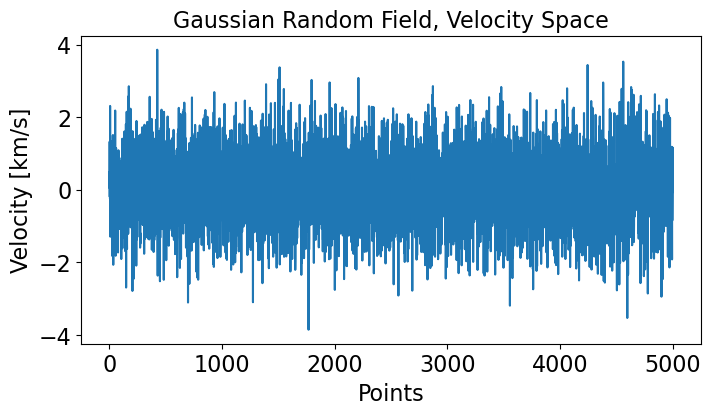

In [32]:
# Generate Gaussian random field in velocity-space
gaussian_random_field = np.random.default_rng(seed).normal(size=size)

# plt.plot(gaussian_random_field)
plt.plot(gaussian_random_field[min_slice:max_slice])
plt.title('Gaussian Random Field, Velocity Space')
plt.xlabel('Points')
plt.ylabel('Velocity [km/s]')

# Check properties
print("mean (velocity-space):  ", gaussian_random_field.mean())
print("stdev (velocity-space):  ", gaussian_random_field.std())
print("shape: ", gaussian_random_field.shape)
print("seed:  ", seed)
print("dv:    ", dv)

## FFT Transformation

 (ii) FFT the grid, and multiply with $\sqrt{P(k) / dv}$ to obtain $ \tilde{\delta}_b(k) $, where dv is the grid spacing in velocity units.

The power spectrum model, $P_G(k)$ comes from the $\xi_G$ best fit.

Inverse FFT and save the variance of this grid, $\sigma^2$. This is a crude Gaussian base for baryon fluctuations, $\delta_b(v)$, with defined power spectrum at $z_0 = 3$.

### FFT on grid

gaussian field k-space shape: (524289,)


Text(0, 0.5, 'Amplitude')

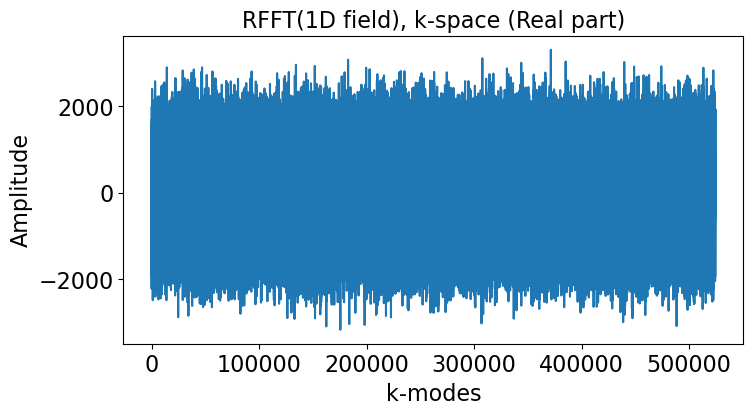

In [33]:
# Compute the FFT to get the field in k-space

gaussian_random_field_k = np.fft.rfft(gaussian_random_field) # normalization ?
print('gaussian field k-space shape: ' + str(gaussian_random_field_k.shape))

plt.plot(np.real(gaussian_random_field_k)) # plot only real part of fft
plt.title('RFFT(1D field), k-space (Real part)')
plt.xlabel('k-modes')
plt.ylabel('Amplitude')

### Make grid of k-modes

In [34]:
# make a grid of k-modes, using same dims as gaussian field
# where d = spacing of the grid

kmodes = (np.fft.rfftfreq(n=size, d=dv) * 2 * np.pi) + 1e-12 # note the factor of 2pi

### Aside: Measuring Power

$$ P(k) = \langle|\tilde{\delta(k)}|^2 \rangle $$

In [35]:
def measure_power(array):
    power = np.abs(array)**2
    return(power)

def measure_scaled_power(array, n, length_scale):
    power = np.abs(array)**2
    scaled_power = power / (n * length_scale)
    return(scaled_power)

Text(0, 0.5, '$ P(k) = \\langle|\\tilde{\\delta(k)}|^2 \\rangle $')

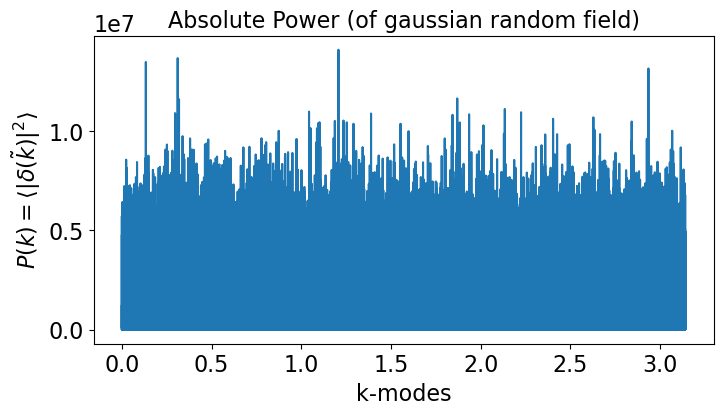

In [36]:
plt.plot(kmodes,measure_power(gaussian_random_field_k))
plt.title('Absolute Power (of gaussian random field)')
plt.xlabel('k-modes')
plt.ylabel(r'$ P(k) = \langle|\tilde{\delta(k)}|^2 \rangle $')

# cannot average across realizations, average across kbins, st each bin has mult. modes (e.g. 8-10 modes)

Text(0, 0.5, 'P(k) / L')

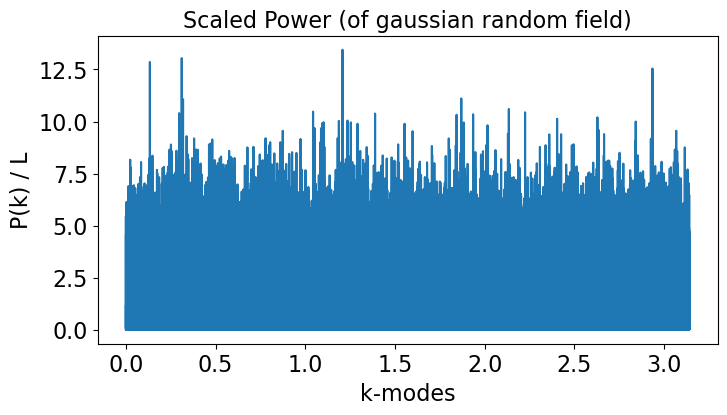

In [37]:
plt.plot(kmodes,measure_scaled_power(gaussian_random_field_k, n = size ,length_scale=1))
plt.title('Scaled Power (of gaussian random field)')
plt.xlabel('k-modes')
plt.ylabel('P(k) / L')


#### Rebinning k-modes

In [38]:
statistic, bin_edges, binnumber = binned_statistic(x = kmodes, values = 
                                                   measure_scaled_power(gaussian_random_field_k, 
                                                    n=size, length_scale=1), 
                                                    statistic = 'mean', bins=40)

In [39]:
print(statistic.shape) # The values of the selected statistic in each bin, mean here
print(bin_edges.shape) # Return the bin edges (length(statistic)+1).
print(binnumber.shape) # Indices of the bins (corresponding to bin_edges) 
                       # in which each value of x belongs. Same length as values 

(40,)
(41,)
(524289,)


Text(0.5, 0, 'k-bins')

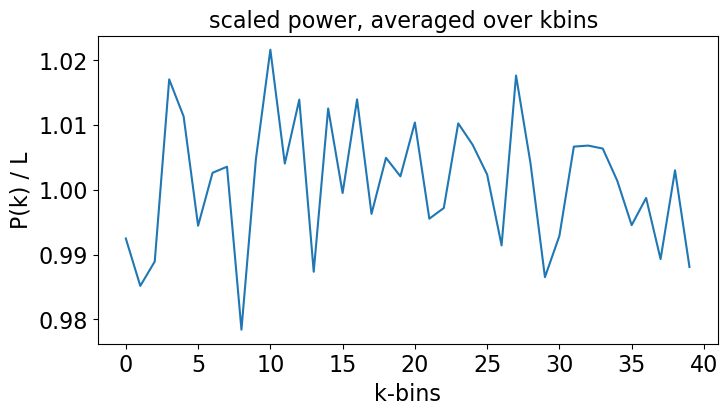

In [40]:
plt.plot(statistic)
plt.title('scaled power, averaged over kbins ')
plt.ylabel('P(k) / L')
plt.xlabel('k-bins')

### Power Spectrum Factor (from file)

Import the gaussian power file (from the fitting code)

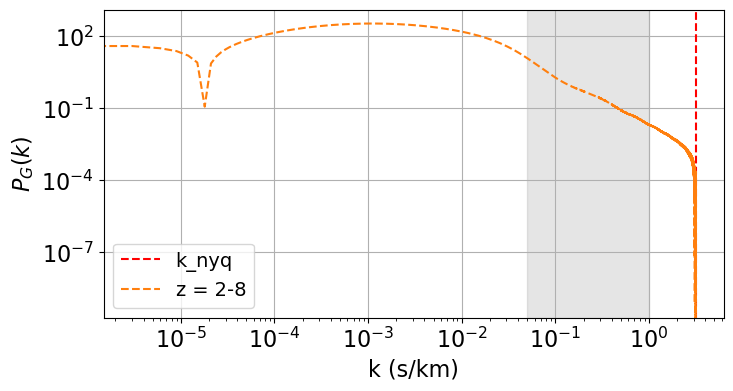

In [41]:

PG_file_path = f'../P_G/P_G-{safe_z}.txt'
data = np.loadtxt(PG_file_path)

# Split into k and P(k)
k_array = data[:, 0]
power_array = data[:, 1]

k_nyquist = np.pi / dv # check Nyquist Frequency
plt.axvline(k_nyquist, color='r', linestyle='--', label='k_nyq')
plt.loglog(k_array, power_array, label=f'z = {safe_z.replace("_", ".")}', color='tab:orange',  ls='--')
plt.ylabel(r'$P_{G}(k)$')
plt.xlabel('k (s/km)')
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.legend()
plt.grid(True)
plt.show()

$P_G$ is not necessarily the same size as the gaussian random field, so we need to adjust its size before multiplying.

In [42]:
def delta_transform_1d(file_k_array, file_power_array, 
                       gaussian_random_field_k, dv):
    """
    Transforms a Gaussian white noise field in k-space to a correlated
    Gaussian field in velocity-space, using an imported power spectrum.

    Parameters:
    - file_k_array: array of k values from the power spectrum file [s/km]
    - file_power_array: array of P(k) values [arbitrary units]
    - gaussian_random_field_k: white noise field in rfft space
    - dv: spacing of the velocity grid [km/s]

    Returns:
    - delta_b_tilde: scaled k-space field
    - delta_b: real-space Gaussian field
    - P_k: interpolated and used power spectrum
    """
    N_rfft = gaussian_random_field_k.shape[0]
    N = 2 * (N_rfft - 1)  # real-space size
    k = np.fft.rfftfreq(N, d=dv) * 2 * np.pi  # k [1/km]
    
    # Interpolate with smooth spline and constant extrapolation
    power_interp = InterpolatedUnivariateSpline(file_k_array, 
                                                file_power_array, 
                                                k=1, ext=1)
    P_k = power_interp(k)

    # Ensure non-negative and finite
    P_k = np.where((P_k > 0) & np.isfinite(P_k), P_k, 0.0)

    # Scale the white noise in k-space
    delta_b_tilde = gaussian_random_field_k * np.sqrt(P_k / dv)

    # Inverse FFT to get real-space correlated Gaussian field
    delta_b = np.fft.irfft(delta_b_tilde, n=N) / dv

    return delta_b_tilde, delta_b, P_k


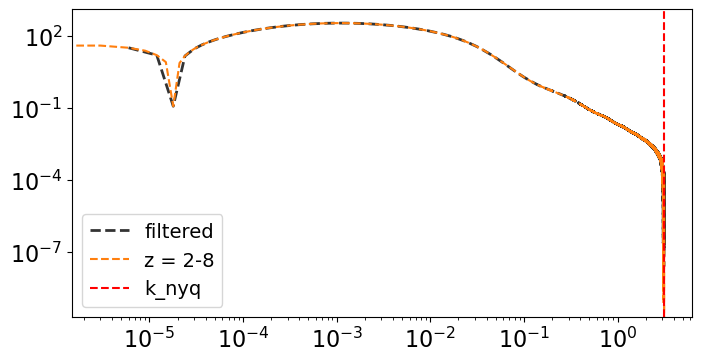

In [43]:
delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(
    k_array, power_array, gaussian_random_field_k, dv)

plt.loglog(kmodes[1:], P_k_filtered[1:], label='filtered', ls='--', lw=2, color='black', alpha=0.8)
plt.loglog(k_array, power_array, label=f'z = {safe_z.replace("_", ".")}', color='tab:orange',  ls='--')
plt.axvline(k_nyquist, color='r', linestyle='--', label='k_nyq')
plt.legend()

Text(0, 0.5, '$\\tilde\\delta_b(k)$')

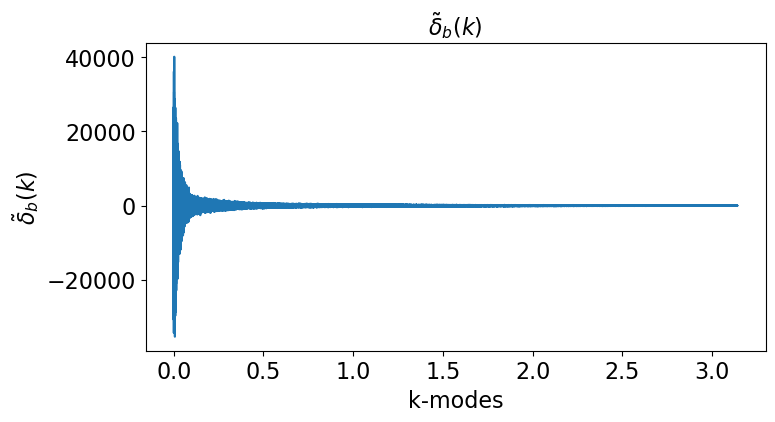

In [44]:
plt.plot(kmodes, np.real(delta_b_tilde))
plt.title(r"$\tilde\delta_b(k)$")
plt.xlabel('k-modes')
plt.ylabel(r"$\tilde\delta_b(k)$")

Variance: 1.5041714648423858


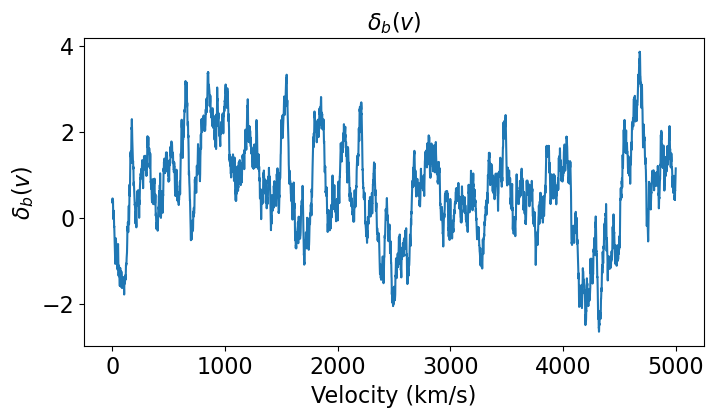

In [45]:
plt.plot(delta_b_v[min_slice:max_slice])
plt.title(r"$\delta_b(v)$")
plt.ylabel(r"$\delta_b(v)$")
plt.xlabel('Velocity (km/s)')

variance_1d = sigma2_fid
variance_1d_field = delta_b_v.var()

print(f'Variance: {variance_1d_field}')

## Redshift Evolution Factor

(iii) Multiply with a redshift evolution factor $a(z)$, such that, 

$\delta_b(z) = a(z)\delta_b(v)$ 

$\sigma^2(z) = a^2(z)\sigma^2(v)$

Redshift evolution: 

$$a^2(z) =  \left( \frac{1+z}{1+z_0} \right) ^{-\nu} $$

where, $z_0 = 3$, and $\nu = 2.16175$, such that: 

$$a(z) =  \left( \frac{1+z}{1+z_0} \right) ^{-\nu / 2} $$


In [46]:
def a2_z(zp, nu=nu_fid, z0=PD13_PIVOT_Z):
    return np.power((1. + zp) / (1.+z0), -nu)


def a_z(zp, nu=nu_fid, z0=PD13_PIVOT_Z):
    return np.sqrt(np.power((1. + zp) / (1.+z0), -nu))

In [47]:
delta_b_z = delta_b_v * a_z(zp = target_redshift)

redshifted_variance_1d = variance_1d * a2_z(zp = target_redshift)
redshifted_variance_1d_field = variance_1d_field * a2_z(zp = target_redshift)

Text(0.5, 1.0, '$\\delta_b(z)$ (z = 2.8)')

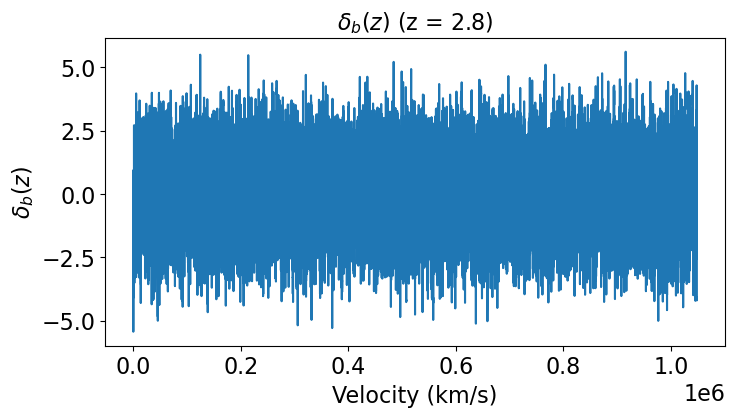

In [48]:
plt.plot(delta_b_z)
plt.ylabel(r'$\delta_b(z)$')
plt.xlabel('Velocity (km/s)')
plt.title(rf'$\delta_b(z)$ (z = {target_redshift})')

## Lognormal Transformation


(iv) Apply a squared lognormal transformtation to approximate the non-linear and non-Gaussian HI column density field:

\begin{align}
n(z) = e^{2\delta_b(z)-\sigma^2(z)}  \tag{22}\\
\end{align}

Text(0.5, 0, 'Velocity (km/s)')

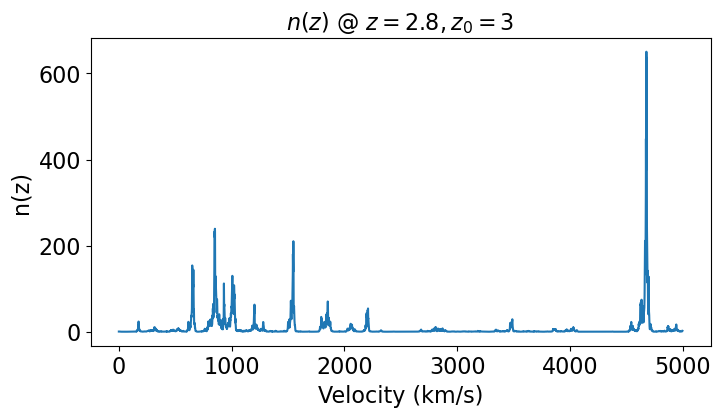

In [49]:
def lognormal_transform(delta_z, sigma2_z):
    n_z = np.exp( (2 * (delta_z) - (sigma2_z)))
    return(n_z)

n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
plt.plot(n_z[min_slice:max_slice])
plt.title(rf'$n(z)$ @ $z = {target_redshift}, z_0 = 3$')
plt.ylabel('n(z)')
plt.xlabel('Velocity (km/s)')

## Optical Depth Transformation

(v) Transform this to optical depth $\tau$ by multiplying with another redshift-dependent function:

Optical Depth: 

$$ \tau(z) = \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} $$

where, $z_0 = 3$, $\tau_0 = 673.77e-3$, and $\tau_1 = 5.31008	$

Then, 

$$ x(z) \rightarrow \tau(z) * n(z) $$


$$ x(z) = \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} * e^{2 \delta(z) - \sigma^2} $$

In [50]:
def t_of_z(zp, tau0=tau0_fid, tau1=tau1_fid, z0= PD13_PIVOT_Z):
    return tau0 * np.power((1. + zp) / (1.+z0), tau1)

def x_of_z(t_z, n_z):
    return t_z * n_z

def f_of_z(x_z):
    return np.exp(-x_z)

In [51]:
t_z = t_of_z(zp=target_redshift)
x_z = x_of_z(t_z, n_z)

Text(0.5, 0, 'Velocity (km/s)')

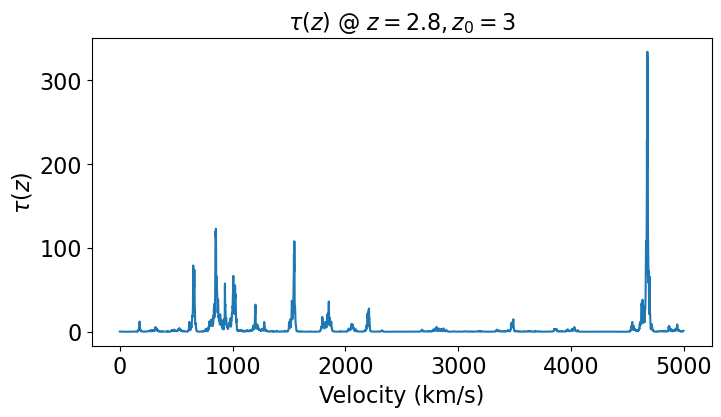

In [52]:
plt.plot(x_z[min_slice:max_slice])
plt.title(rf'$\tau(z)$ @ $z = {target_redshift}, z_0 = 3$')
plt.ylabel(r'$\tau(z)$')
plt.xlabel('Velocity (km/s)')

## Smoothing / Flux

(vi) Finally, the flux is: $ F(z) = e^{-\tau(z)} $

Text(0.5, 0, 'Velocity (km/s)')

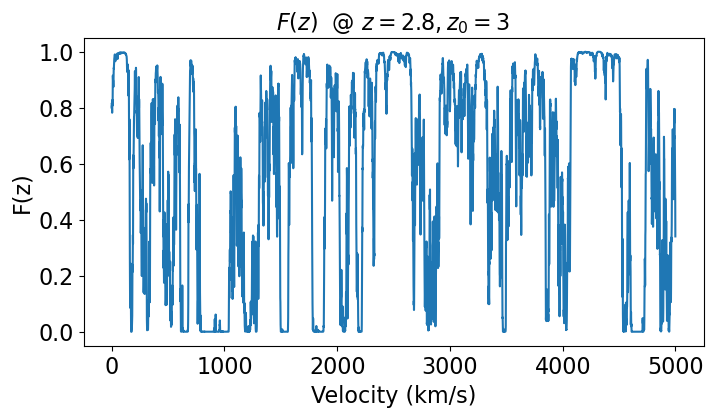

In [53]:
f_z = f_of_z(x_z)

plt.plot(f_z[min_slice:max_slice])
plt.title(rf'$ F(z)$  @ $z = {target_redshift}, z_0 = 3$')
plt.ylabel('F(z)')
plt.xlabel('Velocity (km/s)')

Text(0.5, 0, 'V [km/s]')

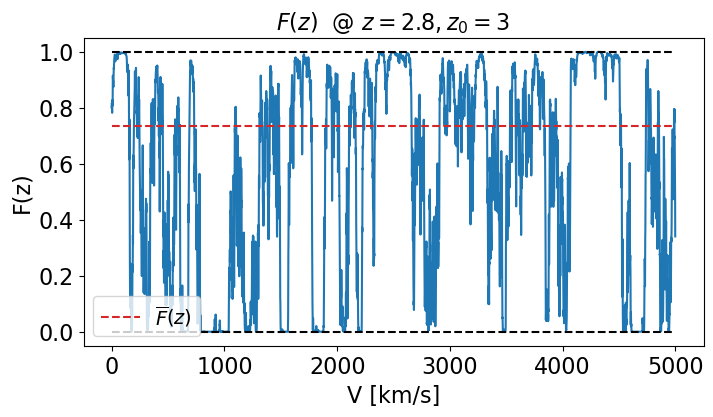

In [54]:
plt.plot(f_z[min_slice:max_slice])
plt.title(rf'$ F(z)$  @ $z = {target_redshift}, z_0 = 3$')
plt.ylabel('F(z)')
plt.hlines(y=0, xmin=0, xmax=5000, color='black', ls='--')
plt.hlines(y=1, xmin=0, xmax=5000, color='black', ls='--')
plt.hlines(y=f_z.mean(), xmin=0,xmax=5000, color='tab:red', ls='--',label=rf'$\overline{{F}}(z)$')
plt.legend(loc = 'lower left')
plt.xlabel('V [km/s]')

#### Transform to wavelength space

$$ v = c \ln(\lambda/\lambda_{pivot}) $$

where, 

$$ \lambda_{pivot} = (1+z_{pivot}) \lambda_{Ly\alpha} $$

and $\lambda_{Ly\alpha} = 1215.67 \dot{A} $. 

So, need to plot flux against the wavelngth grid, given by, 

$$ \lambda = \lambda_{pivot} \exp[(v - v_0) /c] $$

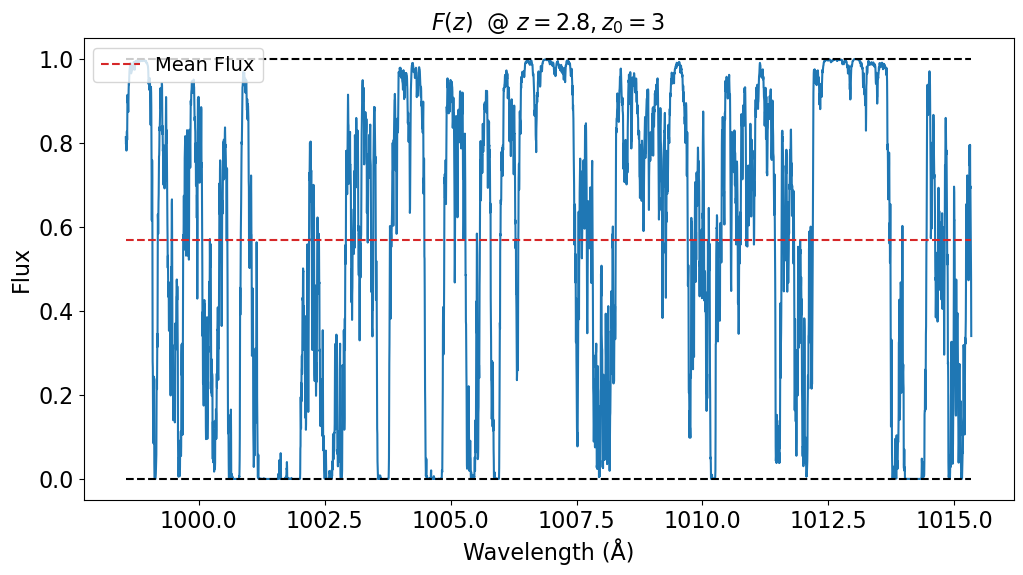

In [55]:
# Generate the wavelength grid
wavelength_field = lambda_c(z=target_redshift)* (np.exp(velocity_grid / c))

# Calculate optical depth for given redshift
tau_z = t_z

# Calculate flux
flux_z = f_z

# Plot the flux vs wavelength
plt.figure(figsize=(12, 6))
plt.plot(wavelength_field[min_slice:max_slice], flux_z[min_slice:max_slice])  # Use wavelength_field for x-axis and flux_z for y-axis
plt.title(rf'$ F(z)$  @ $z = {target_redshift}, z_0 = 3$')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.hlines(y=flux_z[min_slice:max_slice].mean(), xmin=wavelength_field[min_slice:max_slice].min(), xmax=wavelength_field[min_slice:max_slice].max(), color='tab:red', ls='--', label='Mean Flux')
plt.hlines(y=0, xmin=wavelength_field[min_slice:max_slice].min(), xmax=wavelength_field[min_slice:max_slice].max(), color='black', ls='--')
plt.hlines(y=1, xmin=wavelength_field[min_slice:max_slice].min(), xmax=wavelength_field[min_slice:max_slice].max(), color='black', ls='--')
plt.legend(loc = 'upper left')
plt.show()

Interractive flux transmission field using Widgets

In [56]:

def plot_flux(z):
    # Generate the wavelength grid
    wavelength_field = lambda_c(z) * (np.exp(velocity_grid / c))

    # Calculate optical depth for given redshift
    delta_z = delta_b_v * a_z(z)
    redshifted_variance = variance_1d * a2_z(z)
    t_z = t_of_z(z)
    n_z = lognormal_transform(delta_z, redshifted_variance)
    x_z = x_of_z(t_z, n_z)
    flux_z = f_of_z(x_z)
    mean_flux = flux_z.mean()

    # Plot the flux vs wavelength
    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_field[min_slice:max_slice], flux_z[min_slice:max_slice], label='z = '+ str(z))  
    plt.title(r'$ F(z) = e^{-\tau(z)}$')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.hlines(y=mean_flux, xmin=wavelength_field[min_slice:max_slice].min(), 
               xmax=wavelength_field[min_slice:max_slice].max(), color='red', ls='--', 
               label=rf'$\overline{{F}}$ = {mean_flux:.2f}')
    plt.hlines(y=0, xmin=wavelength_field[min_slice:max_slice].min(), xmax=wavelength_field[min_slice:max_slice].max(), color='black', ls='--')
    plt.hlines(y=1, xmin=wavelength_field[min_slice:max_slice].min(), xmax=wavelength_field[min_slice:max_slice].max(), color='black', ls='--')
    plt.legend(loc='lower left')
    plt.show()


interact(plot_flux, z = widgets.FloatSlider(value=target_redshift,
                                                      min=1.0,
                                                      max=5.0,
                                                      step=0.1))


interactive(children=(FloatSlider(value=2.8, description='z', max=5.0, min=1.0), Output()), _dom_classes=('wid…

<function __main__.plot_flux(z)>

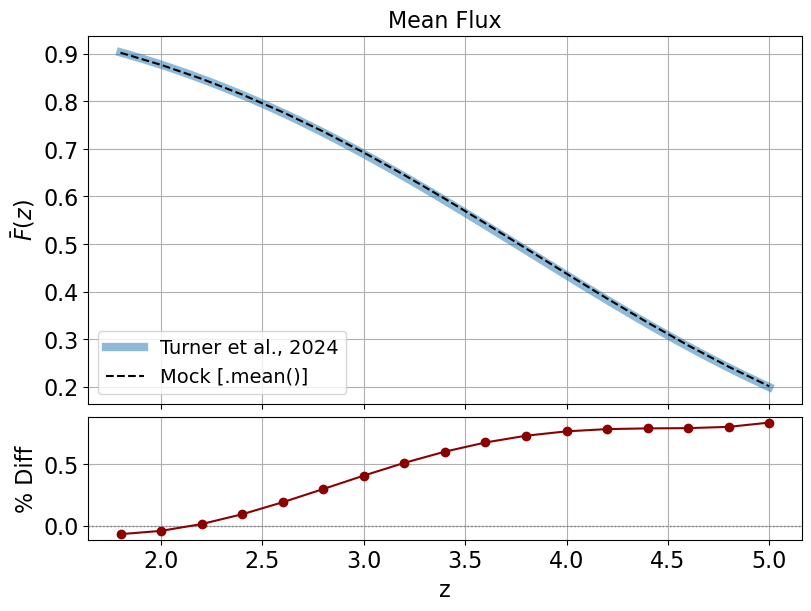

In [57]:
def turner24_mf(z):
    tau_0 = -2.46e-3
    gamma = 3.62
    return np.exp(tau_0 * (1 + z)**gamma)

z_array = np.linspace(1.8, 5.0, 500)
measured_mean_flux = []

zlist = np.array([1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0])

for z in zlist:
    delta_z = delta_b_v * a_z(z)
    redshifted_variance = variance_1d * a2_z(z)
    t_z = t_of_z(z)
    n_z = lognormal_transform(delta_z, redshifted_variance)
    x_z = x_of_z(t_z, n_z)
    flux_z = f_of_z(x_z)
    mean_flux = flux_z.mean()
    measured_mean_flux.append(mean_flux)

# Model and percent difference
model_flux_at_measured_z = turner24_mf(zlist)
residuals = 100 * (np.array(measured_mean_flux) - model_flux_at_measured_z) / model_flux_at_measured_z

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]}, constrained_layout=True)

# Mean flux
ax1.plot(z_array, turner24_mf(z_array), label='Turner et al., 2024', lw=6, alpha=0.5)
ax1.plot(zlist, measured_mean_flux, label='Mock [.mean()]', ls='--', color='black')
ax1.set_ylabel(r'$\bar F(z)$')
ax1.set_title('Mean Flux')
ax1.legend(loc='lower left')
ax1.grid()

# Percent difference
ax2.axhline(0, color='gray', lw=1, ls=':')
ax2.plot(zlist, residuals, marker='o', color='darkred')
ax2.set_xlabel('z')
ax2.set_ylabel('% Diff')
ax2.grid()

plt.show()


### Mean Flux

Them mean flux and power spectrum of these mocks can be analytically computed. Using one-point probability of the base Gaussian random field, $\delta$, we can write down the following integral for the mean flux: 

$$ \bar{F}(z) = \frac{1}{\sigma \sqrt{2\pi}} \int_{-\infty}^{\infty} \exp{[-\frac{\delta^2}{2 \sigma^2} - x(z) e^{2 a(z)\delta}]d\delta} $$

where, 

$$ x(z) \equiv \tau_0 (\frac{1+z}{1+z_0})^{\tau_1} e^{-a^2(z)\sigma^2} $$

In [58]:
# the following are used for the GHQ mean flux calculation

def prefactor(variance):
    prefactor = 1 / (np.sqrt(variance) * np.sqrt(2 * np.pi))
    return(prefactor)

def x_z_flux(z, sigma2, tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3):
    return t_of_z(z, tau0, tau1, z0) * np.exp(-a2_z(z, nu, z0) * sigma2)

def mean_flux(z, variance, z0=3):
    integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z_flux(z, variance)) * np.exp(2 * (a_z(z)) * x)))
    integral = integrate.quad(integrand, -np.inf, np.inf)[0]
    value = prefactor(variance) * integral
    return(value)

In [59]:
print(f'Turner 24: {turner24_mf(target_redshift)}')
print(f'np.mean  : {f_z.mean()}')
print(f'GHQ mean : {mean_flux(z=target_redshift, variance=variance_1d, z0=3)}')

Turner 24: 0.7342887533400222
np.mean  : 0.7364701620312776
GHQ mean : 0.7343589164408849


/tmp/ipykernel_1054536/1000986928.py:11: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z_flux(z, variance)) * np.exp(2 * (a_z(z)) * x)))


#### Mean Flux vs Redshift

In [60]:
z_list = np.array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6,
       3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5.0])

In [61]:
flux_list = []
for i in z_list:
    flux_list.append(mean_flux(z=i,variance=variance_1d, z0=3))

/tmp/ipykernel_1054536/1000986928.py:11: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z_flux(z, variance)) * np.exp(2 * (a_z(z)) * x)))


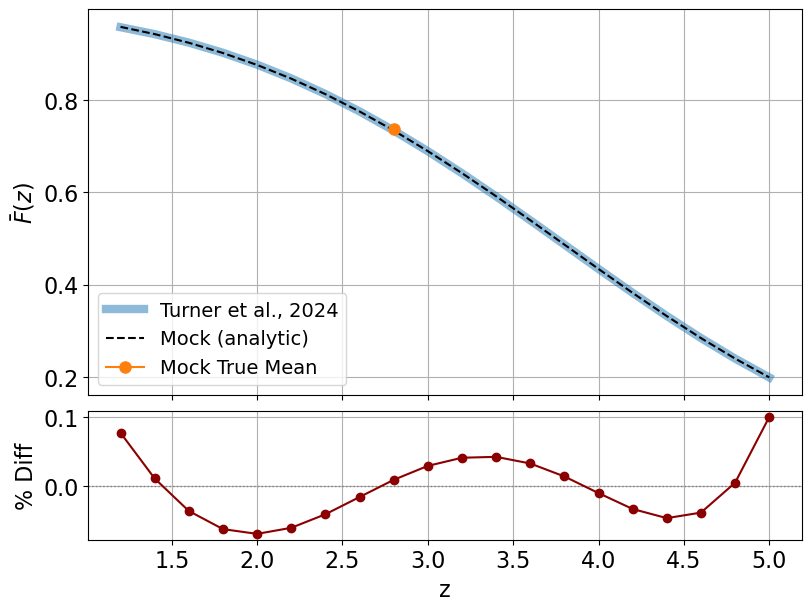

In [62]:
# Turner et al. (2024) model
turner_flux = np.exp(-2.46e-3 * (1 + z_list)**3.62)

# Calculate percent difference
residuals = 100 * (flux_list - turner_flux) / turner_flux

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), 
                               gridspec_kw={'height_ratios': [3, 1]}, 
                               constrained_layout=True)

# Top panel: mean flux comparison
ax1.plot(z_list, turner_flux, label='Turner et al., 2024', lw=6, alpha=0.5)
ax1.plot(z_list, flux_list, label='Mock (analytic)', ls='--', color='black')
ax1.plot(target_redshift, f_z.mean(), label='Mock True Mean', marker='o', markersize=8)
ax1.set_ylabel(r'$\bar F(z)$')
# ax1.set_title('Mean Flux Comparison')
ax1.legend(loc='lower left')
ax1.grid()

# Bottom panel: percent difference
ax2.axhline(0, color='gray', lw=1, ls=':')
ax2.plot(z_list, residuals, marker='o', color='darkred')
ax2.set_xlabel('z')
ax2.set_ylabel('% Diff')
ax2.grid()

plt.show()


### Measure Power

The next test would be to measure the power spectrum, using the ratio of flux / mean flux (analytical), and comparing to the power of the gaussian random field. 

Define flux power spectrum (FPS) as: 

$$ \delta_F \equiv \frac{F - \langle F \rangle}{\langle F \rangle} $$

Where $\langle F \rangle$ is the average flux ($\overline F$)

$$ P_F(k) = \delta_f(k) * \delta_f(k) $$
where $\delta_F(k)$ is the Fourier transform of the flux overdensity.

In [63]:
def delta_F(z, variance, input_flux, z0=PD13_PIVOT_Z):
    f_bar = input_flux.mean()
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    return(delta_f)

def P_F(delta_f, dv):
    L = delta_f.size * dv
    delta_f_tilde = np.fft.rfft(delta_f) * dv
    P_F = np.abs(delta_f_tilde)**2 / L
    return P_F

In [64]:

test_flux = f_z
delta_f = delta_F(z = target_redshift, 
                  variance = variance_1d_field, 
                  input_flux = f_z)
test_power = P_F(delta_f, dv)

N = len(delta_f)

kmodes2 = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi

window = (kmodes2 > 1e-5) & (kmodes2 < 0.05)  # Window for k_arr


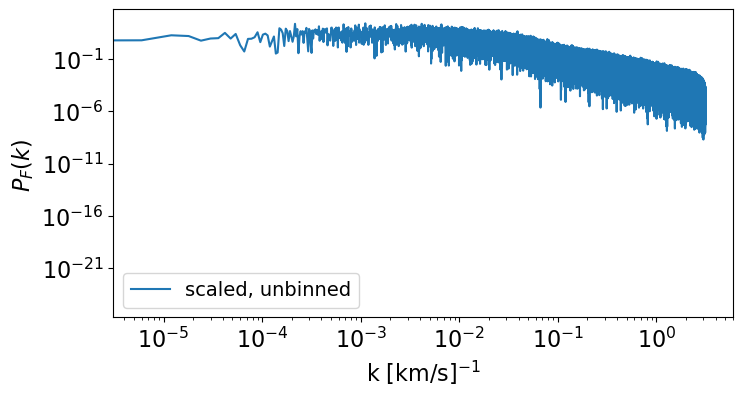

In [65]:
plt.loglog(kmodes2, test_power, label='scaled, unbinned')
plt.ylabel(r'$P_F(k)$ ')
plt.xlabel('k [km/s$]^{-1}$')
plt.legend()

In [70]:
def fit_PD13Lorentz(delta_f, dv, z):
    power = P_F(delta_f, dv)
    N = len(delta_f)
    kmodes = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi
    # w_k =  (kmodes > 0) & (kmodes < 10e1)   
    w_k =  (kmodes > 0) & (kmodes < 10e2)   
    bins = 20000
    statistic, bin_edges, binnumber = binned_statistic(x=kmodes[w_k],
                                                       values=power[w_k],
                                                       statistic='mean', 
                                                       bins = bins)    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
 
    window = (bin_centers > 0) & (bin_centers < 1.0)  

    valid = np.isfinite(statistic) & np.isfinite(bin_centers)
    bin_centers = bin_centers[valid]
    statistic = statistic[valid]

    p0 = (0.07, -2.5, -0.1, 3.5, 0.3, 700)
    
    popt_mock, pcov_mock = curve_fit(
        lambda k, A, n, alpha, B, beta, lmd: evaluatePD13Lorentz(
            (k,z), A, n, alpha, B, beta, lmd),
        bin_centers, statistic, p0=p0, maxfev=20000)
    
    return bin_centers[window], statistic[window], *popt_mock

def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10
    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)
    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
    return result

In [74]:
bin_centers, stat, *popt_mock_param = fit_PD13Lorentz(delta_f, dv, 
                                                      target_redshift)

desi_model = evaluatePD13Lorentz((bin_centers, target_redshift), 
                                 *DESI_EDR_PARAMETERS)
naim_fit = evaluatePD13Lorentz((bin_centers, target_redshift), 
                               *Naim_2020_parameters)

percent_diff_mock_measure = 100 * (stat - desi_model) / desi_model
percent_diff_naim_fit     = 100 * (naim_fit - desi_model) / desi_model

/tmp/ipykernel_1054536/3600036756.py:32: RuntimeWarning: overflow encountered in power
  result = (A * np.pi / PD13_PIVOT_K) * np.power(
/tmp/ipykernel_1054536/3600036756.py:36: RuntimeWarning: overflow encountered in power
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
/tmp/ipykernel_1054536/3600036756.py:36: RuntimeWarning: overflow encountered in multiply
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
/tmp/ipykernel_1054536/3600036756.py:36: RuntimeWarning: invalid value encountered in multiply
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)


In [75]:
# 2023 edr measurement k-bins
z_2_0_wk = (bin_centers > 0.001250) & (bin_centers < 0.021170)
z_2_2_wk = (bin_centers > 0.000750) & (bin_centers < 0.023753)
z_2_4_wk = (bin_centers > 0.000750) & (bin_centers < 0.023753)
z_2_8_wk = (bin_centers > 0.000750) & (bin_centers < 0.026651)
z_3_0_wk = (bin_centers > 0.000750) & (bin_centers < 0.029903)
z_3_2_wk = (bin_centers > 0.000750) & (bin_centers < 0.029903)
z_3_4_wk = (bin_centers > 0.000750) & (bin_centers < 0.029903)
z_3_6_wk = (bin_centers > 0.000750) & (bin_centers < 0.033552)
z_3_8_wk = (bin_centers > 0.000750) & (bin_centers < 0.033552)

# 2020 mock paper k-range
wk_2020 = (bin_centers > 0.0005) & (bin_centers < 0.112)

# EDR measurement k-range
wk_2023 = (bin_centers > 0.000750) & (bin_centers < 0.035) # EDR measurement 

# 2025 measurement k-range
c = 299792.458        # km/s
delta_lambda = 0.8    # Angstrom (DESI)
lambda_lya = 1215.67  # Angstrom

def get_k_range_desi2025(z):
    """Return kmin and kmax (in s/km) for DESI DR1 resolution at redshift z."""
    R_z = (c * delta_lambda) / ((1 + z) * lambda_lya)
    k_max = 0.5 * np.pi / R_z  # s/km
    k_min = 0.001  # s/km, fixed by continuum limit
    return k_min, k_max

dynamic_k_min, dynamic_k_max = get_k_range_desi2025(target_redshift)
wk_2025 = (bin_centers > dynamic_k_min) & (bin_centers < dynamic_k_max) 



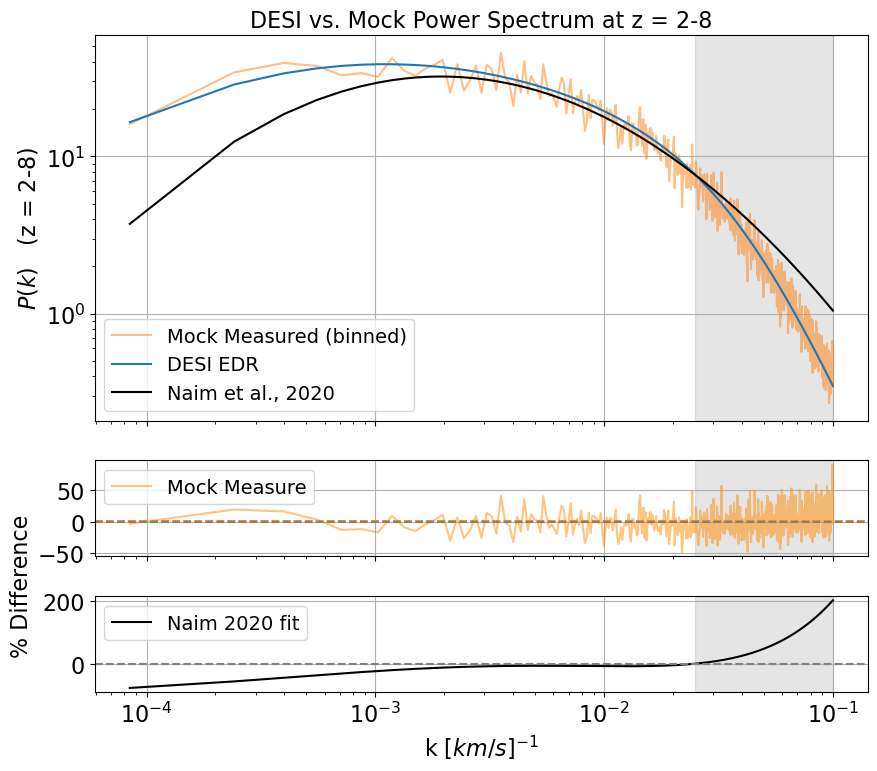

In [76]:

#### PLOT MEASURED POWER ####

w_k = (bin_centers > 1e-5) & (bin_centers < 0.1) 

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 8), sharex=True, 
                                    gridspec_kw={'height_ratios': [4, 1, 1]})

ax1.loglog(bin_centers[w_k], stat[w_k], color='tab:orange', 
           label='Mock Measured (binned)', alpha=0.5)
ax1.loglog(bin_centers[w_k], desi_model[w_k], 
           color='tab:blue', label=r'DESI EDR')
ax1.loglog(bin_centers[w_k], naim_fit[w_k], 
    color='black', label=r'Naim et al., 2020')



ax1.set_ylabel(rf'$P(k)$   (z = {safe_z})')
ax1.legend(loc='lower left')
ax1.grid(True)
ax1.set_title(f'DESI vs. Mock Power Spectrum at z = {safe_z}')
ax1.axvspan(0.025, 0.1, alpha=0.2, color='grey')


ax2.semilogx(bin_centers[w_k], percent_diff_mock_measure[w_k], alpha=0.5,
             color='darkorange', label='Mock Measure')
ax2.axhline(percent_diff_mock_measure[w_k].mean(), ls='--', color='darkorange')
ax2.axhline(0, ls='--', color='gray')
ax2.grid(True)
ax2.legend(loc='upper left')
ax2.axvspan(0.025, 0.1, alpha=0.2, color='grey')


ax3.semilogx(bin_centers[w_k], percent_diff_naim_fit[w_k], 
             color='black', label='Naim 2020 fit')
ax3.axhline(0, ls='--', color='gray')
ax3.set_xlabel(r'k $[km/s]^{-1}$')
ax3.grid(True)
ax3.axvspan(0.025, 0.1, alpha=0.2, color='grey')

fig.text(0.02, 0.25, "% Difference", va='center', rotation='vertical', fontsize=16)
ax3.set_ylabel("")  # remove individual y-labels to avoid overlap

plt.legend()
plt.tight_layout()



### Compare to DESI EDR Data

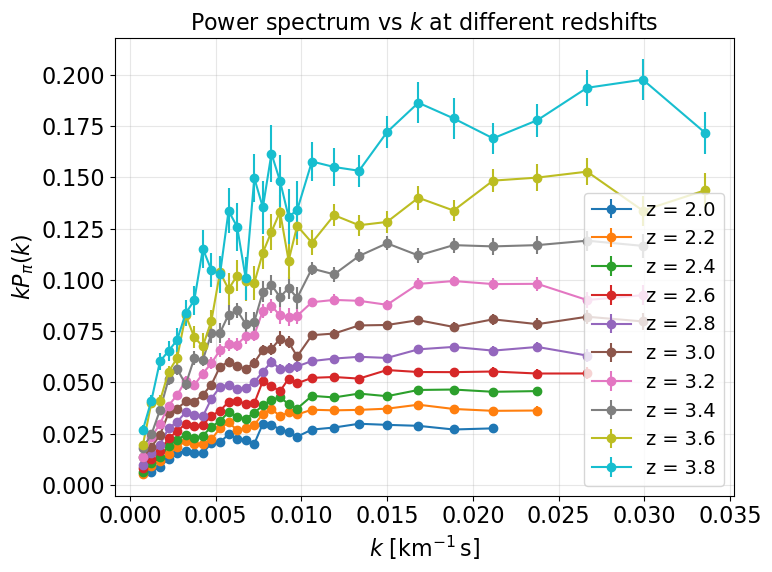

In [77]:

edr_data_path = '../Examples/figure8_qmle_desiedrp_results.txt'

# Read the file, using '|' as a separator and stripping whitespace
df = pd.read_csv(edr_data_path, sep='|', skiprows=1)
df = df.drop(columns=df.columns[[0, -1]])  # Drop extra empty columns from leading/trailing pipes
df.columns = ['kc', 'z', 'kPpi', 'kepi']   # Rename columns
df = df.apply(pd.to_numeric)               # Ensure all data is numeric

plt.figure(figsize=(8, 6))
for z_val, group in df.groupby('z'):
    plt.errorbar(group['kc'], group['kPpi'], yerr=group['kepi'], fmt='o-', label=f'z = {z_val}')

plt.xlabel(r'$k$ [$\mathrm{km}^{-1}\,\mathrm{s}$]')
plt.ylabel(r'$kP_{\pi}(k)$')
plt.title("Power spectrum vs $k$ at different redshifts")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



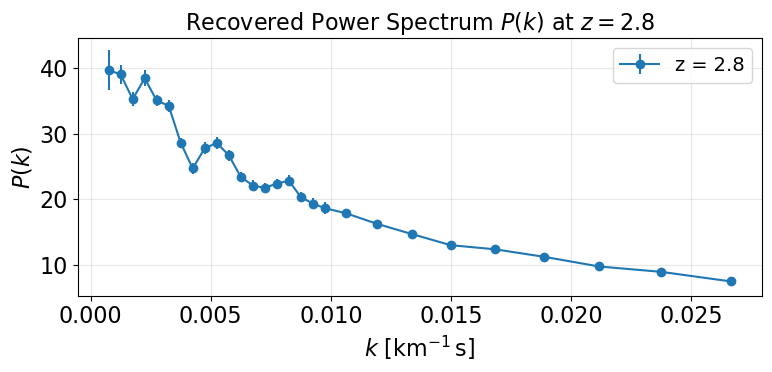

In [78]:
z_target = target_redshift
subset = df[df['z'] == z_target].copy()

# Recover P(k) and its uncertainty
subset['Pk'] = np.pi * subset['kPpi'] / subset['kc']
subset['Pk_err'] = np.pi * subset['kepi'] / subset['kc']

# Plot
plt.errorbar(subset['kc'], subset['Pk'], yerr=subset['Pk_err'], fmt='o-', label=f'z = {z_target}')
plt.xlabel(r'$k$ [$\mathrm{km}^{-1}\,\mathrm{s}$]')
plt.ylabel(r'$P(k)$')
plt.title(f"Recovered Power Spectrum $P(k)$ at $z={z_target}$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# print(f'kmin = {subset['kc'][:].min()}')
# print(f'kmax = {subset['kc'][:].max()}')



In [79]:
def process_EDR_DATA(z_target):
    edr_data_path = edr_data_path = '../Examples/figure8_qmle_desiedrp_results.txt'

    # Read the file, using '|' as a separator and stripping whitespace
    df = pd.read_csv(edr_data_path, sep='|', skiprows=1)
    df = df.drop(columns=df.columns[[0, -1]])  # Drop extra empty columns from leading/trailing pipes
    df.columns = ['kc', 'z', 'kPpi', 'kepi']   # Rename columns
    df = df.apply(pd.to_numeric)               # Ensure all data is numeric

    subset = df[df['z'] == z_target].copy()
    
    # Recover P(k) and its uncertainty
    subset['Pk'] = np.pi * subset['kPpi'] / subset['kc']
    subset['Pk_err'] = np.pi * subset['kepi'] / subset['kc']

    return subset['kc'], subset['Pk'], subset['Pk_err']

test_edr_k, test_edr_p, test_edr_err = process_EDR_DATA(target_redshift)

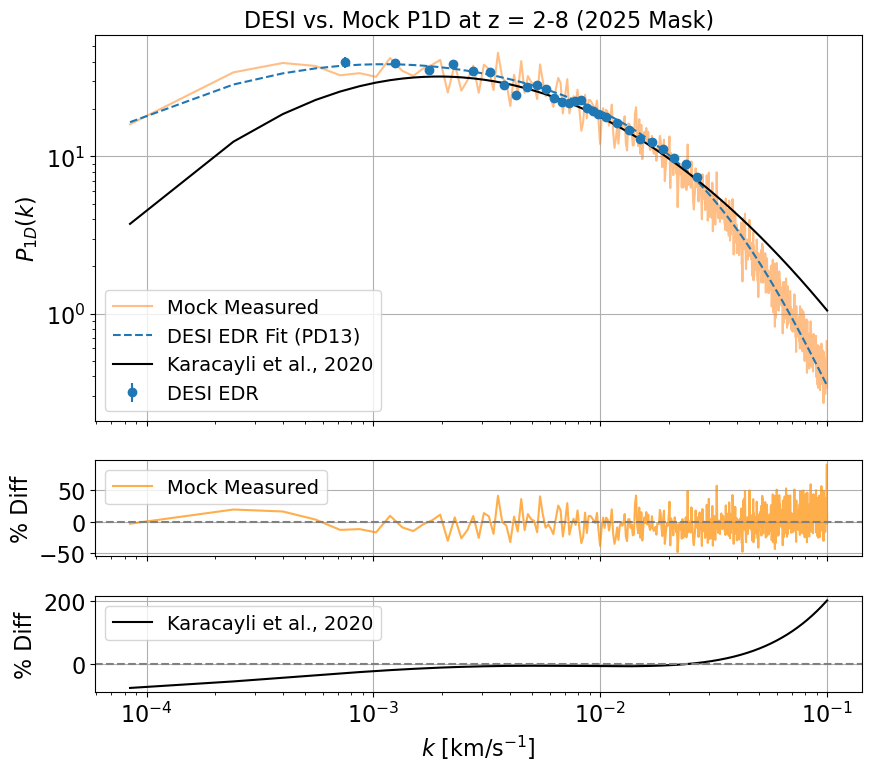

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 8), 
                                    sharex=True, 
                                    gridspec_kw={'height_ratios': [4, 1, 1]})

mask = (bin_centers > 1e-5) & (bin_centers < 0.1) 

# Upper plot
ax1.loglog(bin_centers[mask], stat[mask], color='tab:orange', label='Mock Measured', alpha=0.5)
ax1.loglog(bin_centers[mask], desi_model[mask], 
    color='tab:blue', label=r'DESI EDR Fit (PD13)', ls='--')
ax1.errorbar(subset['kc'], subset['Pk'], yerr=subset['Pk_err'], 
             fmt='o', label='DESI EDR', color='tab:blue')#, markerfacecolor='none')
ax1.loglog(bin_centers[mask], naim_fit[mask], 
    color='black', label=r'Karacayli et al., 2020')
ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.legend(loc='lower left')
ax1.grid(True)
ax1.set_title(f'DESI vs. Mock P1D at z = {safe_z} (2025 Mask)')

# Lower plot (residuals)
ax2.semilogx(bin_centers[mask], percent_diff_mock_measure[mask], 
             color='darkorange', label='Mock Measured', alpha=0.7)
ax2.axhline(0, ls='--', color='gray')
ax2.set_ylabel('% Diff')
ax2.grid(True)
ax2.legend(loc='upper left')

ax3.semilogx(bin_centers[mask], percent_diff_naim_fit[mask], 
             color='black', label='Karacayli et al., 2020')
ax3.axhline(0, ls='--', color='gray')
ax3.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax3.set_ylabel('% Diff')
ax3.grid(True)

plt.legend()
plt.tight_layout()
plt.show()


## Aside(s)

### Aside: Gauss-Hermite Quadrature Integration

$$ \int_{-\infty}^{\infty} e^{-x^2}dx \approx \Sigma_{i=1}^n  w_i f(x_i) $$

where, 

$ n = $ number of sample points,

$x_i = $ roots of Hermite Polynomial

$w_i = $ associated weights

#### numpy.polynomial.hermite.hermgauss

Computes the sample points and weights for Gauss-Hermite quadrature. These sample points and weights will correctly integrate polynomials of degree $2 * deg -1$ or less over the interval [-inf, inf], with weight function $f(x) = exp(x^2)$

$$ \bar{F}(z) = \frac{1}{\sigma \sqrt{2\pi}} \int_{-\infty}^{\infty} \exp{[-\frac{\delta^2}{2 \sigma^2} - x(z) e^{2 a(z)\delta}]d\delta} $$

where, 

$$ x(z) \equiv 0.55 (\frac{1+z}{1+z_0})^{5.1} e^{-a^2(z)\sigma^2} $$

To modify for Gauss-Hermite quadrature: 

$$ I = \int_{-\infty}^{\infty} e^{- \frac{\delta^2}{2 \sigma^2}} \times e^{-x(z)\times e^{2 a(z) \delta}} d\delta$$

$$ I = \int_{-\infty}^{\infty} \exp ( - \frac{\delta^2}{2 \sigma^2} - x(z) \times e^{2 a(z) \delta} )  d\delta $$

Simplify by substituting $\alpha = \frac{1}{2 \sigma^2}$ and $\beta = x(z)$. Then: 

$$ I = \int_{-\infty}^{\infty} \exp(-\alpha \delta^2 - \beta e^{2 a(z)\delta}) d\delta $$

In the Gauss-Hermite quadrature framework, we need the form of $\int_{-\infty}^{\infty} e^{-x^2}f(x)dx$, so we make the changes: 

$$ \delta = \sqrt{2 \sigma^2}x $$

and

$$ d\delta = \sqrt{2 \delta^2}dx $$

then, substituting:

$$ I = \int_{-\infty}^{\infty} \exp(-\frac{(\sqrt{2\sigma^2}x)^2}{2\sigma^2} - \beta e^{2 a(z) \sqrt{2\sigma^2}x})\times \sqrt{2 \sigma^2}x dx$$

$$ I = \sqrt{2 \sigma^2} \int_{-\infty}^{\infty} \exp(-x^2 - \beta e^{2 a(z) \sqrt{2\sigma^2}x}) dx $$

Then, we need to idenltify f(x) for the approximation: 

$$ f(x) = \exp(-\beta e^{2 a(z)\sqrt{2\sigma^2}x}) $$

And in the form of Gauss-Hermite quadrature, we can rewrite the integral: 

$$ \int_{-\infty}^{\infty} e^{x^2} f(x)dx \approx \Sigma_{i=1}^{N}w_i \times f(x_i) $$

becomes:

$$ I \approx \sqrt{2\sigma^2} \Sigma_{i=1}^{N}w_i \times \exp(- \beta e^{2 a(z) \sqrt{2\sigma^2}x_i}) $$

where $x_i$ and $w_i$ are the nodes and weights of for Gauss-Hermite quadrature.